In [1]:
import numpy as np
import struct
from scipy import fftpack
from PIL import Image
from bitarray import bitarray, util
import os
from IPython.display import display

import constants
from huffman import Huffman
import jpeg_decoder

In [2]:
def p2dct(pixels):
    return fftpack.dct(fftpack.dct(pixels, axis=0, norm='ortho'), axis=1, norm='ortho')

def get_header(img_height, img_width, quant_table):
    buf = bytearray()

    def writebyte(val):
        buf.extend(struct.pack(">B", val))

    def writeshort(val):
        buf.extend(struct.pack(">H", val))

    # SOI
    writeshort(0xFFD8)  # SOI marker

    # APP0
    writeshort(0xFFE0)  # APP0 marker
    writeshort(0x0010)  # segment length
    writebyte(0x4A)     # 'J'
    writebyte(0x46)     # 'F'
    writebyte(0x49)     # 'I'
    writebyte(0x46)     # 'F'
    writebyte(0x00)     # '\0'
    writeshort(0x0101)  # v1.1
    writebyte(0x00)     # no density unit
    writeshort(0x0001)  # X density = 1
    writeshort(0x0001)  # Y density = 1
    writebyte(0x00)     # thumbnail width = 0
    writebyte(0x00)     # thumbnail height = 0

    # DQT
    quant_table = quant_table.reshape(-1)
    writeshort(0xFFDB)  # DQT marker
    writeshort(0x0043)  # segment length
    writebyte(0x00)     # table 0, 8-bit precision (0)
    for index in constants.zz:
        writebyte(quant_table[index])

    # SOF0
    writeshort(0xFFC0)  # SOF0 marker
    writeshort(0x000B)  # segment length
    writebyte(0x08)     # 8-bit precision
    writeshort(img_height)
    writeshort(img_width)
    writebyte(0x01)     # 1 component only (grayscale)
    writebyte(0x01)     # component ID = 1
    writebyte(0x11)     # no subsampling
    writebyte(0x00)     # quantization table 0

    # DHT
    writeshort(0xFFC4)                     # DHT marker
    writeshort(19 + constants.dc_nb_vals)  # segment length
    writebyte(0x00)                        # table 0 (DC), type 0 (0 = Y, 1 = UV)
    for node in constants.dc_nodes[1:]:
        writebyte(node)
    for val in constants.dc_vals:
        writebyte(val)

    writeshort(0xFFC4)                     # DHT marker
    writeshort(19 + constants.ac_nb_vals)
    writebyte(0x10)                        # table 1 (AC), type 0 (0 = Y, 1 = UV)
    for node in constants.ac_nodes[1:]:
        writebyte(node)
    for val in constants.ac_vals:
        writebyte(val)

    # SOS
    writeshort(0xFFDA)  # SOS marker
    writeshort(8)       # segment length
    writebyte(0x01)     # nb. components
    writebyte(0x01)     # Y component ID
    writebyte(0x00)     # Y HT = 0
    # segment end
    writebyte(0x00)
    writebyte(0x3F)
    writebyte(0x00)

    return buf

extension_map = {
    '.txt': 0,
    '.ico': 1,
}

def read_msg(filename):
    extension = os.path.splitext(filename)[1]
    byte = np.fromfile(filename, dtype=np.uint8)
    byte = np.append(byte, extension_map[extension]).astype(np.uint8)
    bit = np.unpackbits(byte)
    return bit

def read_msg_2(filename):
    extension = os.path.splitext(filename)[1]
    f = open(filename, 'rb')
    t = bitarray()
    t.fromfile(f)
    t.frombytes(extension_map[extension].to_bytes(1, "big"))
    return t

# print(''.join(str(x) for x in read_msg('msg.txt')))
# print(read_msg_2('msg.txt'))
# print(read_msg_2('msg3.ico'))

def read_img(filename, isRGB = False):
    image = Image.open(filename)
    if isRGB:
        image = image.convert('YCbCr')
    return np.array(image)

# print(read_img('cover.bmp').shape)

def block2d(image_pixels, image_size, block_size):
    for i in range(0, image_size[0], block_size[0]):
        for j in range(0, image_size[1], block_size[1]):
            yield image_pixels[i:i + block_size[0], j:j + block_size[1]].astype(int)

def embed_bits_to_dct_block(msg_bits, dct, quant_table, k):
    stego = np.copy(dct)
    i = 0
    for r in range(dct.shape[0]):
        for c in range(dct.shape[1]):
            if quant_table[r, c] == 1:
                b = util.ba2int(msg_bits[i:i+k])
                stego[r, c] = (dct[r, c] >> k << k) | b
                i += k
    return stego

def zigzag(dct: np.ndarray) -> np.ndarray:
    zz = constants.zz
    flat_dct = dct.flat
    return np.array([flat_dct[i] for i in zz], dtype=int)

In [3]:
quant_table = np.array([
    16, 11, 10, 16,  1,  1,  1,  1,
    12, 12, 14,  1,  1,  1,  1, 55,
    14, 13,  1,  1,  1,  1, 69, 56,
    14,  1,  1,  1,  1, 87, 80, 62,
     1,  1,  1,  1, 68, 109, 103, 77,
     1,  1,  1, 64, 81, 104, 113, 92,
     1,  1, 78, 87, 103, 121, 120, 101,
     1, 92, 95, 98, 112, 100, 103, 99
]).reshape(8, 8)

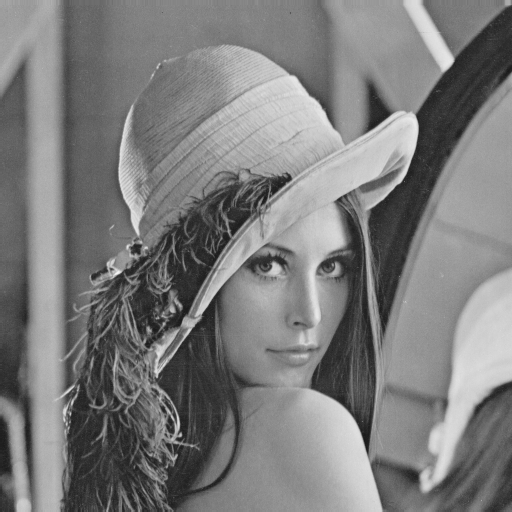

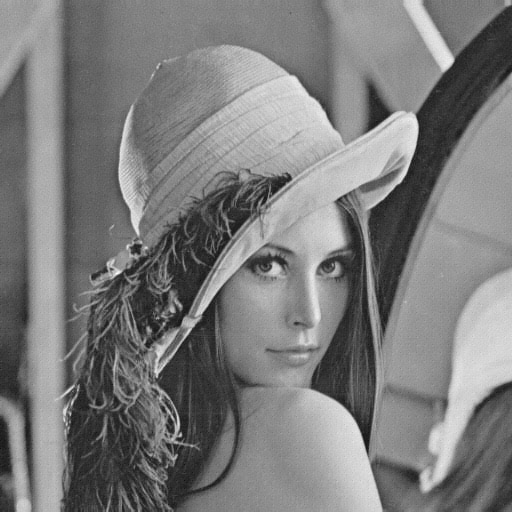

In [4]:
def embed_grayscale_img(msg_file, cover_img_file, quant_table: np.ndarray, stego_img_file, k = 1):
    cover_pixels = read_img(cover_img_file)
    image_size = cover_pixels.shape
    block_size = quant_table.shape
    total_block = (image_size[0] * image_size[1]
                   ) // (block_size[0] * block_size[1])
    embed_bits_per_block = k * np.count_nonzero(quant_table == 1)

    msg_bits = read_msg_2(msg_file) # bitarray
    capacity = total_block * embed_bits_per_block
    if len(msg_bits) + 1 > capacity:
        return False
    msg_bits.extend('1' + '0' * (capacity - len(msg_bits) - 1))
    b_i = 0

    huf = Huffman()
    jpeg_bytes = bytearray()
    header = get_header(image_size[0], image_size[1], quant_table)
    jpeg_bytes.extend(header)

    for block in block2d(cover_pixels, image_size, block_size):
        dct_block = p2dct(block - 128)
        quant_dct_block = np.round(dct_block / quant_table).astype(int)

        cur_bits = msg_bits[b_i:b_i + embed_bits_per_block]
        stego_dct_block = embed_bits_to_dct_block(cur_bits, quant_dct_block, quant_table, k)
        b_i += embed_bits_per_block

        dct_zz = zigzag(stego_dct_block)
        try:
            length = np.max(np.nonzero(dct_zz)) + 1
        except:
            length = -1
        huf.encode_block(dct_zz, length)

    jpeg_bytes.extend(huf.end_and_get_buffer())
    jpeg_bytes.extend(struct.pack(">H", 0xFFD9))  # EOI marker

    with open(stego_img_file, 'wb') as f:
        f.write(jpeg_bytes)

    return True

cover_path = 'cover/cover.bmp'
msg_path = 'msg/msg3.ico'
stego_path = 'stego/stego.jpg'
k = 3

display(Image.open(cover_path))
result = embed_grayscale_img(msg_path, cover_path, quant_table, stego_path, k)
assert result == True
display(Image.open(stego_path))

In [5]:
extension_map_reverse = {
    0: '.txt',
    1: '.ico'
}

def extract_bits_per_blocks(block, quant_table, k):
    t = bitarray()
    mask = (1 << k) - 1
    for r in range(block.shape[0]):
        for c in range(block.shape[1]):
            if quant_table[r, c] == 1:
                t.extend(util.int2ba(int(block[r,c] & mask), k))
    return t

def extract(stego_img_file, extr_msg_file, k = 1):
    quant_dct_coefs, quant_table = jpeg_decoder.get_quant_dct_coefs_and_quant_table(stego_img_file)
    step = quant_table.shape[0] * quant_table.shape[1]
    extr_msg_bits = bitarray()
    for i in range(0, quant_dct_coefs.shape[0], step):
        quant_dct = quant_dct_coefs[i:i+step]
        cur_bits = extract_bits_per_blocks(quant_dct.reshape(quant_table.shape), quant_table, k)
        extr_msg_bits.extend(cur_bits)

    extr_msg_bits = extr_msg_bits[:extr_msg_bits.to01().rfind('1')]
    ext = util.ba2int(extr_msg_bits[-8:])
    extr_msg = extr_msg_bits[:-8].tobytes()
    with open(extr_msg_file + extension_map_reverse[ext], 'wb') as f:
        f.write(extr_msg)
    return extr_msg_file + extension_map_reverse[ext]

extract_path = 'extract/extr_msg'
extract(stego_path, extract_path, k)

'extract/extr_msg.ico'